# Binary Classification

### 1. Importing Libraries and Reading Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.decomposition import PCA
from sklearn import model_selection, svm
from sklearn import feature_selection
from sklearn.feature_selection import RFECV

from sklearn.model_selection import GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, f1_score,roc_auc_score, roc_curve, auc, precision_score, recall_score

import os
os.chdir('E:/PGP-DSE/Capstone Project/Group 2/OnlineNewsPopularity')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) # ignore all future warnings

### 2. Reading the dataset

In [2]:
df = pd.read_csv('ONPClass.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,class
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,0
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,0
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,0
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,0


In [3]:
df = df.drop(['url','timedelta'],axis=1)

## 3. Custom Functions
- These functions are created as they are to be used repeatedly and to reduce the lines of code


In [4]:
# train test split
def perform_train_test_split(x,y,size):
    return train_test_split(x, y, test_size = size, random_state = 0)

# function for scaling the data for train test split
def std_data(xtrain,xtest):
    sc = StandardScaler()
    scaled = sc.fit(xtrain)
    scaled_train = sc.transform(xtrain)
    scaled_test = sc.transform(xtest)
    return scaled_train, scaled_test

# function to scale whole data
def std_all_data(x):
    sc = StandardScaler()
    scaled = sc.fit_transform(x)
    return scaled


# function to apply rfecv onto the dataset
def apply_rfecv(x,y):

    RF = RandomForestClassifier(random_state=0)
    rfecv = RFECV(estimator= RF, step = 5, cv=5, scoring='roc_auc')
    rfecv.fit(x, y)
    
    print("Optimal number of features : %d" % rfecv.n_features_)
    
    rfe_features = pd.DataFrame({'features': x.columns, 'rank':rfecv.ranking_}).sort_values(by = 'rank')
    sel_features = rfe_features[rfe_features['rank']==1]['features'].to_list()
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Score")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    return sel_features
    
# function for applying random search cv
def random_search_cv(x,y,model,params):
    RS = RandomizedSearchCV(model, params, cv = 5, scoring = 'roc_auc', random_state = 0)
    RS.fit(x,y)
    return RS.best_params_, RS.best_estimator_, RS.best_score_

# function for applying grid search cv
def grid_search_cv(x,y,model,params):
    GS = GridSearchCV(model, params, cv = 5, scoring = 'roc_auc')
    GS.fit(x,y)
    return GS.best_params_

# creating an empty dataframe with headers
headers=['AUC Train','AUC Test','Acc Train','Acc Test','Pre Train','Pre Test','Re Train','Re Test']
dfObj = pd.DataFrame(columns = headers)


# function to get roc_auc_scores for train and test  
def fit_predict_plot(xtrain,xtest,ytrain,ytest,models):
    
    for name, model in models:
        
        model.fit(xtrain,ytrain)
        
        y_pred_train = model.predict(xtrain)
        y_pred_test = model.predict(xtest)
        
        probas_train = model.predict_proba(xtrain)[:,1]
        probas_test = model.predict_proba(xtest)[:,1]

        model_name = name 
        
        plot_roc_auc_curve(probas_train,probas_test,ytrain,ytest,name)
        
        return get_metrics(ytrain,ytest,y_pred_train,y_pred_test,probas_train,probas_test,model_name)
    
    
# function to plot the roc auc curve
def plot_roc_auc_curve(probas_train,probas_test,y_train,y_test,name):
    
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train,probas_train)

        fpr_test, tpr_test, thresholds_test = roc_curve(y_test,probas_test)

        
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
        plt.plot(fpr_train, tpr_train, color='b', 
                 label=r'Train ROC (AUC = %0.2f )' % (roc_auc_score(y_train,probas_train)),lw=2, alpha=.5)
        plt.plot(fpr_test, tpr_test, color='g', 
                 label=r'Test ROC (AUC = %0.2f )' % (roc_auc_score(y_test,probas_test)),lw=2, alpha=.8)

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate',fontsize=10)
        plt.ylabel('True Positive Rate',fontsize=10)
        plt.title('ROC of %s' % (name),fontsize=10)
        plt.legend(loc="lower right", prop={'size': 9})
        plt.show()

        

    
# function to get all other metrics
def get_metrics(y_train,y_test,y_pred_train,y_pred_test,probas_train,probas_test,name):
        global dfObj
        print('Confusion Matrix:\n')
        print('For Train Data:\n')
        print(confusion_matrix(y_train,y_pred_train))
        #print(classification_report(y_train,y_pred_train))
        
        print('\n For Test Data:\n')
        print(confusion_matrix(y_test,y_pred_test))
        #print(classification_report(y_test,y_pred_test))

        dfObj.loc[name] = [roc_auc_score(y_train,probas_train), roc_auc_score(y_test,probas_test),
                           accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test),
                           precision_score(y_train, y_pred_train), precision_score(y_test, y_pred_test),
                           recall_score(y_train, y_pred_train), recall_score(y_test, y_pred_test)]
        return dfObj
        

# function for applying various models
def implement_cv(x,y,models):
    final = {}
    results = []
    names = []
    auc = []
    for name,model in models:
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        cv_results = model_selection.cross_val_score(model,x,y,cv=kfold, scoring='roc_auc')
        results.append((np.abs(cv_results)))
        auc.append(np.mean(results))
        names.append(name)
        print(cv_results)
        final.update({'Model': names , 'roc_auc_score': auc})
    return pd.DataFrame(final)



Splitted the data into train and test sets using ratio 70:30

## Considering all features

In [9]:
X_all = df.drop(['class'],axis = 1 )

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X_all,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardizing the train and test sets

In [10]:
X_all.shape, X_train.shape

((39644, 58), (27750, 58))

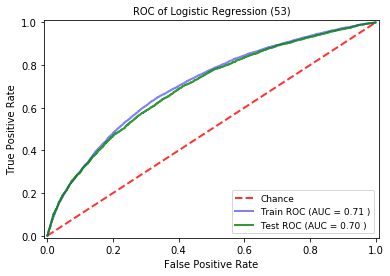

Confusion Matrix:

For Train Data:

[[9471 4539]
 [5009 8731]]

 For Test Data:

[[4030 2042]
 [2199 3623]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression (53),0.706896,0.697685,0.655928,0.643434,0.65795,0.639541,0.635444,0.622295


In [7]:
# default parameters
LOGREG = LogisticRegression(random_state = 0, max_iter = 1000) 

models = [('Logistic Regression (53)', LOGREG)]

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

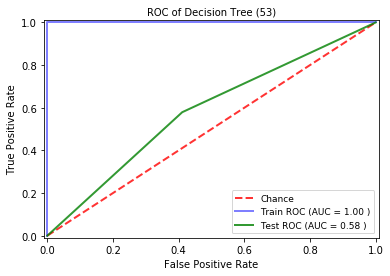

Confusion Matrix:

For Train Data:

[[14010     0]
 [    0 13740]]

 For Test Data:

[[3577 2495]
 [2450 3372]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression (53),0.706896,0.697685,0.655928,0.643434,0.65795,0.639541,0.635444,0.622295
Decision Tree (53),1.000000,0.584140,1.000000,0.584244,1.00000,0.574740,1.000000,0.579182


In [8]:
# with default parameters

default_DT = DecisionTreeClassifier(random_state = 0)

models = []
models.append(('Decision Tree (53)', default_DT))

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

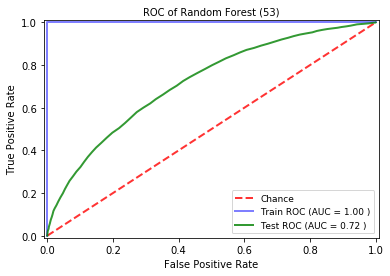

Confusion Matrix:

For Train Data:

[[14010     0]
 [    0 13740]]

 For Test Data:

[[4066 2006]
 [2094 3728]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression (53),0.706896,0.697685,0.655928,0.643434,0.65795,0.639541,0.635444,0.622295
Decision Tree (53),1.000000,0.584140,1.000000,0.584244,1.00000,0.574740,1.000000,0.579182
Random Forest (53),1.000000,0.718974,1.000000,0.655288,1.00000,0.650157,1.000000,0.640330


In [9]:
# default parameters

default_RF = RandomForestClassifier(random_state = 0)

models = []
models.append(('Random Forest (53)',default_RF))

fit_predict_plot(train,test,y_train,y_test,models)

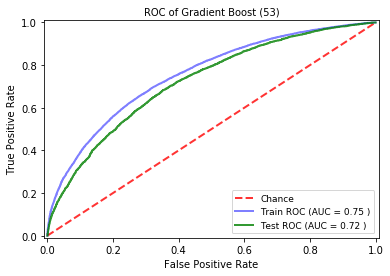

Confusion Matrix:

For Train Data:

[[9713 4297]
 [4403 9337]]

 For Test Data:

[[4081 1991]
 [2019 3803]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression (53),0.706896,0.697685,0.655928,0.643434,0.657950,0.639541,0.635444,0.622295
Decision Tree (53),1.000000,0.584140,1.000000,0.584244,1.000000,0.574740,1.000000,0.579182
Random Forest (53),1.000000,0.718974,1.000000,0.655288,1.000000,0.650157,1.000000,0.640330
Gradient Boost (53),0.754509,0.722535,0.686486,0.662855,0.684832,0.656369,0.679549,0.653212


In [10]:
# with default parameters
default_GB = GradientBoostingClassifier(random_state = 0)

models = []
models.append(('Gradient Boost (53)',default_GB))

fit_predict_plot(train,test,y_train,y_test,models)

In [ ]:
## SVM default parameters

default_SVM = svm.SVC(probability = True,random_state = 0)

models = []
models.append(('SVM',default_SVM))

fit_predict_plot(train,test,y_train,y_test,models)

In [11]:
# run only if required 
dfObj.drop(dfObj.index, inplace=True)

## Considering significant features (final)

In [5]:
X = df.drop(['class','avg_negative_polarity','min_negative_polarity','max_negative_polarity','abs_title_subjectivity',
            'weekday_is_friday'],axis = 1 )

Y = df['class']

X_train, X_test, y_train, y_test = perform_train_test_split(X,Y,0.3) # splitting the dataset

train, test = std_data(X_train, X_test) # standardizing the train and test sets

X.shape, X_train.shape

((39644, 53), (27750, 53))

## 4. Model Implementation

### 4.1 Base model Logistic Regression


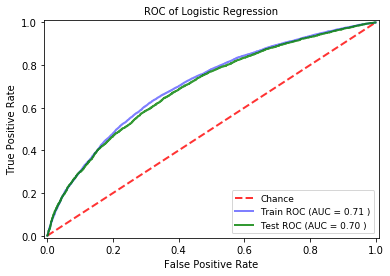

Confusion Matrix:

For Train Data:

[[9460 4550]
 [4991 8749]]

 For Test Data:

[[4023 2049]
 [2195 3627]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression,0.706581,0.697509,0.65618,0.643181,0.657869,0.639006,0.636754,0.622982


In [13]:
# initialized parameters
LOGREG = LogisticRegression(random_state = 0 ,max_iter = 1000) 

models = [('Logistic Regression', LOGREG)]

fit_predict_plot(train, test, y_train, y_test, models) # implementing the model

### 4.2  Decision Tree

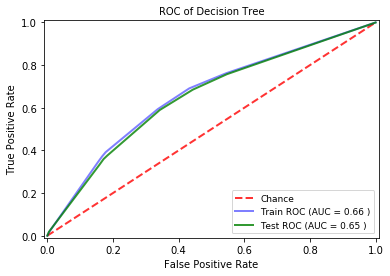

Confusion Matrix:

For Train Data:

[[9298 4712]
 [5584 8156]]

 For Test Data:

[[3992 2080]
 [2389 3433]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression,0.706581,0.697509,0.656180,0.643181,0.657869,0.639006,0.636754,0.622982
Decision Tree,0.658214,0.649808,0.628973,0.624264,0.633820,0.622710,0.593595,0.589660


In [14]:
# initialized parameters
DT = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 10, min_samples_split = 11, random_state = 0)

models = []
models.append(('Decision Tree',DT))

fit_predict_plot(train,test,y_train,y_test,models)

## Implementing Ensemble Models

### 4.3 Random Forest

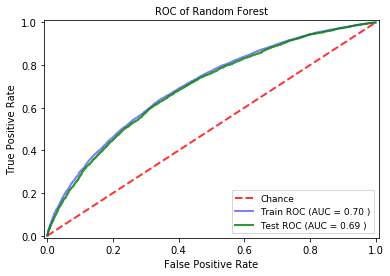

Confusion Matrix:

For Train Data:

[[9286 4724]
 [5067 8673]]

 For Test Data:

[[4002 2070]
 [2181 3641]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression,0.706581,0.697509,0.656180,0.643181,0.657869,0.639006,0.636754,0.622982
Decision Tree,0.658214,0.649808,0.628973,0.624264,0.633820,0.622710,0.593595,0.589660
Random Forest,0.701367,0.692956,0.647171,0.642593,0.647384,0.637542,0.631223,0.625386


In [15]:
# initialized parameters

RF = RandomForestClassifier(max_depth = 3, min_samples_split = 11, min_samples_leaf = 10,random_state = 0)

models = []
models.append(('Random Forest',RF))

fit_predict_plot(train,test,y_train,y_test,models)

### Gradient Boost

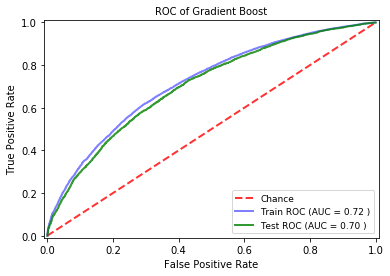

Confusion Matrix:

For Train Data:

[[9356 4654]
 [4764 8976]]

 For Test Data:

[[3965 2107]
 [2087 3735]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
Logistic Regression,0.706581,0.697509,0.656180,0.643181,0.657869,0.639006,0.636754,0.622982
Decision Tree,0.658214,0.649808,0.628973,0.624264,0.633820,0.622710,0.593595,0.589660
Random Forest,0.701367,0.692956,0.647171,0.642593,0.647384,0.637542,0.631223,0.625386
Boosted Decision Tree,0.732882,0.708357,0.668721,0.651169,0.669728,0.647505,0.652911,0.630711
Boosted Random Forest,0.747595,0.721972,0.680757,0.662014,0.678464,0.654175,0.675255,0.656647
Gradient Boost,0.719067,0.703941,0.660613,0.647385,0.658547,0.639336,0.653275,0.641532


In [20]:
# initialized parameters
GB = GradientBoostingClassifier(max_depth = 3, min_samples_split = 11, min_samples_leaf = 10, 
                                n_estimators = 20, random_state = 0)

models = []
models.append(('Gradient Boost',GB))

fit_predict_plot(train,test,y_train,y_test,models)

## Support Vector Machine

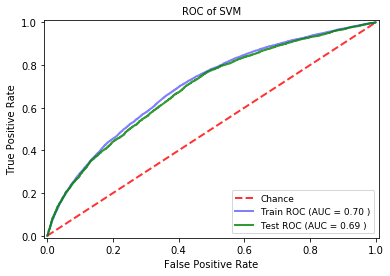

Confusion Matrix:

For Train Data:

[[9208 4802]
 [5050 8690]]

 For Test Data:

[[3919 2153]
 [2210 3612]]


,AUC Train,AUC Test,Acc Train,Acc Test,Pre Train,Pre Test,Re Train,Re Test
SVM,0.699929,0.689926,0.644973,0.633176,0.644085,0.626539,0.63246,0.620405


In [7]:
default_SVM = svm.SVC(kernel = 'linear', gamma = 'auto', probability = True,random_state = 0)

models = []
models.append(('SVM',default_SVM))

fit_predict_plot(train,test,y_train,y_test,models)

## Comaprison of Models

In [21]:
# dataframe styles
th_props = [
  ('font-size', '11px'),
  ('text-align', 'left'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px'),
  ('text-align', 'left'),
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]


def compare_models():
    
    final_scores = dfObj

    final_scores.columns = ['Train','Test','Train','Test','Train','Test','Train','Test']

    headers = pd.MultiIndex.from_product([['ROC_AUC','ACCURACY','PRECISION','RECALL'],['Train','Test']])

    final_scores.columns = headers

    return final_scores.style.set_table_styles(styles)

    #final_scores['ACCURACY'], final_scores['ACCURACY'].plot(kind ='bar')

### Models with significant features and initialized parameters

In [22]:
compare_models()

## Evaluation  of the final models

In [9]:
# base estimators for AB_DT and AB_RF
DT = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 10, min_samples_split = 11, random_state = 0)

RF = RandomForestClassifier(max_depth = 3, min_samples_split = 11, min_samples_leaf = 10,random_state = 0)

tuned_AB_DT = AdaBoostClassifier(base_estimator = DT, n_estimators = 12, random_state = 0) 

tuned_AB_RF = AdaBoostClassifier(base_estimator = RF, n_estimators = 15, random_state = 0) 

tuned_GB = GradientBoostingClassifier(n_estimators = 100,learning_rate = 0.1, max_depth = 3, 
                                min_samples_split = 10, min_samples_leaf = 20, random_state = 0)

from sklearn.ensemble import VotingClassifier
stacked = VotingClassifier(estimators=[('abrf',tuned_AB_RF), ('gb',tuned_GB)], voting='soft')
stacked2 = VotingClassifier(estimators=[('abdt',tuned_AB_DT), ('abrf',tuned_AB_RF), ('gb',tuned_GB)], voting='soft')



In [41]:
def evaluate_model(x,y,models):
    
    for name,model in models:
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        cv_results = model_selection.cross_validate(model,x,y,cv=kfold, scoring='roc_auc',return_train_score = True)
        train_cv_score = [i for i in cv_results['train_score']]
        test_cv_score = [i for i in cv_results['test_score']]
        print('Train Scores: ',train_cv_score)
        print('Test Scores: ',test_cv_score)
        print('Mean Train Scores: ', np.mean(train_cv_score))
        print('MeanTest Scores: ', np.mean(test_cv_score))
        
        #plt.figure(figsize = (5,5))
        #plt.ylim([0,100])
        #plt.plot(np.arange(1,6,1),train_cv_score, label=r'Train Mean %0.2f )' % (np.mean(train_cv_score)),lw=2, alpha=.5)
        #plt.plot(np.arange(1,6,1),test_cv_score, label=r'Test Mean %0.2f )' % (np.mean(test_cv_score)),lw=2, alpha=.5)
        #plt.legend(loc="best", prop={'size': 9})
        #plt.show()
        
        
def implement_cv(x,y,models):
    final = {}
    results = []
    names = []
    auc = []
    for name,model in models:
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        cv_results = model_selection.cross_val_score(model,x,y,cv=kfold, scoring='roc_auc')
        results.append((np.abs(cv_results)))
        auc.append(np.mean(results))
        names.append(name)
        #print(cv_results)
        final.update({'Model': names , 'accuracy': auc})
    return pd.DataFrame(final)


In [17]:
models = []
models.append(('Boosted DT',tuned_AB_DT))
evaluate_model(X,Y,models)

Train Scores:  [73.30245923447578, 73.28211030680359, 73.06802441761225, 73.27963217889463, 72.85822466899916]
Test Scores:  [70.7020084575344, 70.89129477551634, 70.96738969136823, 70.49412650956943, 71.69911943919165]
Mean Train Scores:  73.15809016135708
MeanTest Scores:  70.950787774636


In [23]:
models = []
models.append(('Boosted RF',tuned_AB_RF))
evaluate_model(X,Y,models)

Train Scores:  [0.754073517798735, 0.7541651630597961, 0.7522460959399436, 0.7529250548478862, 0.7500990829486144]
Test Scores:  [0.725523344157229, 0.7237926979654636, 0.7314602159936284, 0.7302842803725593, 0.74030313449086]
Mean Train Scores:  0.752701782918995
MeanTest Scores:  0.7302727345959481


In [24]:
models = []
models.append(('Gradient Boost',tuned_GB))
evaluate_model(X,Y,models)

Train Scores:  [0.750188088945519, 0.7508887121061139, 0.7483285144459667, 0.7494040749049278, 0.7470098238393145]
Test Scores:  [0.7247133980560274, 0.722293711606669, 0.7294109516899494, 0.7261680652379586, 0.7357323680909722]
Mean Train Scores:  0.7491638428483683
MeanTest Scores:  0.7276636989363153


In [25]:
models = []
models.append(('Stacked Model',stacked))
evaluate_model(X,Y,models)

Train Scores:  [0.7507260941640838, 0.7513820634093042, 0.7488433592423356, 0.7499208520046015, 0.7474900722973843]
Test Scores:  [0.7250276432659604, 0.7226320692406664, 0.729843025488918, 0.726693380449354, 0.7363245022571135]
Mean Train Scores:  0.7496724882235417
MeanTest Scores:  0.7281041241404025


In [26]:
models = []
models.append(('Stacked Model2',stacked2))
evaluate_model(X,Y,models)

Train Scores:  [0.7514536678559418, 0.7516440595232068, 0.7492089133666795, 0.7503673338939078, 0.7476268412868219]
Test Scores:  [0.7252021284519072, 0.7231542249049036, 0.729778118968307, 0.726374749240165, 0.7362140978867815]
Mean Train Scores:  0.7500601631853115
MeanTest Scores:  0.7281446638904129


## Mean Accuracies

In [11]:
models = []
models.append(('Boosted DT',tuned_AB_DT))

implement_cv(X,Y,models)

,Model,accuracy
0,Boosted DT,0.653668


In [12]:
models = []
models.append(('Boosted RF',tuned_AB_RF))
implement_cv(X,Y,models)

,Model,accuracy
0,Boosted RF,0.667794


In [13]:
models = []
models.append(('Gradient Boost',tuned_GB))
implement_cv(X,Y,models)

,Model,accuracy
0,Gradient Boost,0.667289


In [14]:
models = []
models.append(('Stacked Model',stacked))
implement_cv(X,Y,models)

,Model,accuracy
0,Stacked Model,0.667138


## Mean ROC AUC

In [30]:

models = []
models.append(('Boosted RF',tuned_AB_RF))
implement_cv(X,Y,models)




[0.72552334 0.7237927  0.73146022 0.73028428 0.74030313]


,Model,roc_auc_score
0,Boosted RF,0.730273


In [34]:

models = []
models.append(('Gradient Boost',tuned_GB))
implement_cv(X,Y,models)




[0.7247134  0.72229371 0.72941095 0.72616807 0.73573237]


,Model,roc_auc_score
0,Gradient Boost,0.727664


In [35]:

models = []
models.append(('Stacked Model',stacked))
implement_cv(X,Y,models)

[0.72502764 0.72263207 0.72984303 0.72669338 0.7363245 ]


,Model,roc_auc_score
0,Stacked Model,0.728104


## FINAL ROC AUC PLOT

In [55]:
def plot_roc_auc_curve(x,y,model):
    
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        plt.figure(figsize=(5,5))
        i = 0
        
        kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
        
        for i, (train_index, test_index) in enumerate(kfold.split(x)):
            X_train, X_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            probas_test = model.fit(X_train,y_train).predict_proba(X_test)[:,1]
            
            fpr, tpr, thresholds = roc_curve(y_test,probas_test)
            
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc)) # plot for each fold

            i += 1
            
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8) # chnace

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=.8) # plot for mean auc

        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        plt.xlabel('False Positive Rate',fontsize=10)
        plt.ylabel('True Positive Rate',fontsize=10)
        plt.title(r'Cross-Validation ROC',fontsize=10)
        plt.legend(loc="lower right", prop={'size': 9})
        plt.show()

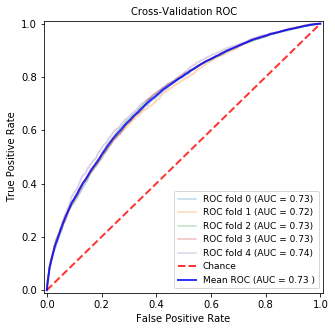

In [56]:
plot_roc_auc_curve(X,Y,tuned_AB_RF)